In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM

In [3]:
company = 'UBER'
stock_data = pd.read_csv("UBER stock.csv", parse_dates=['Date'], sep=',', index_col='Date')

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-10,42.000000,45.000000,41.060001,41.570000,41.570000,186322500
2019-05-13,38.790001,39.240002,36.080002,37.099998,37.099998,79442400
2019-05-14,38.310001,39.959999,36.849998,39.959999,39.959999,46661100
2019-05-15,39.369999,41.880001,38.950001,41.290001,41.290001,36086100
2019-05-16,41.480000,44.060001,41.250000,43.000000,43.000000,38115500
...,...,...,...,...,...,...
2022-03-18,32.520000,33.419998,32.330002,33.360001,33.360001,35779700
2022-03-21,32.820000,32.820000,31.250000,31.980000,31.980000,35200600
2022-03-22,31.930000,33.599998,31.840000,33.349998,33.349998,21852800


# Plotting UBER stock closing prices

Text(0.5, 1.0, 'UBER stock closing price')

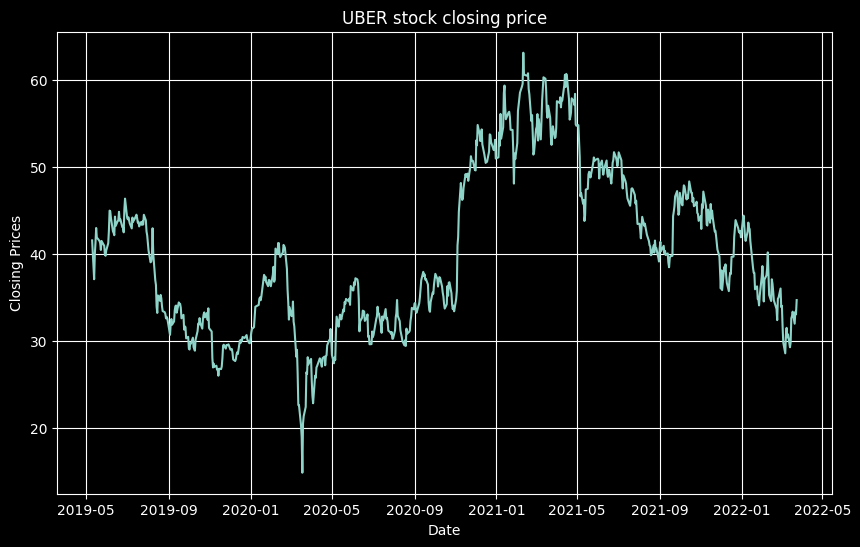

In [42]:
df_close = stock_data['Close']
plt.style.use('dark_background')
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('UBER stock closing price')

In [51]:
def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''

    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

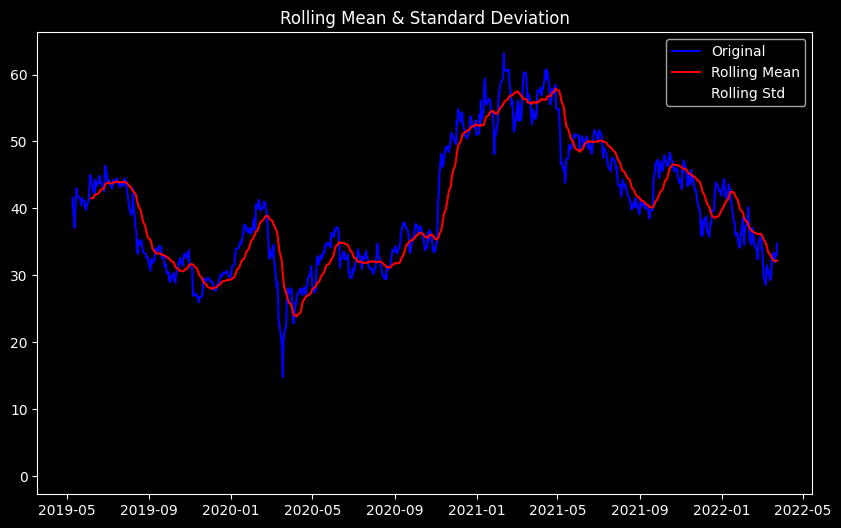

Results of Dickey-Fuller Test:
Test Statistic                  -2.044689
p-value                          0.267329
#Lags Used                       2.000000
Number of Observations Used    722.000000
Critical Value (1%)             -3.439440
Critical Value (5%)             -2.865551
Critical Value (10%)            -2.568906
dtype: float64


In [43]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

<Figure size 640x480 with 0 Axes>

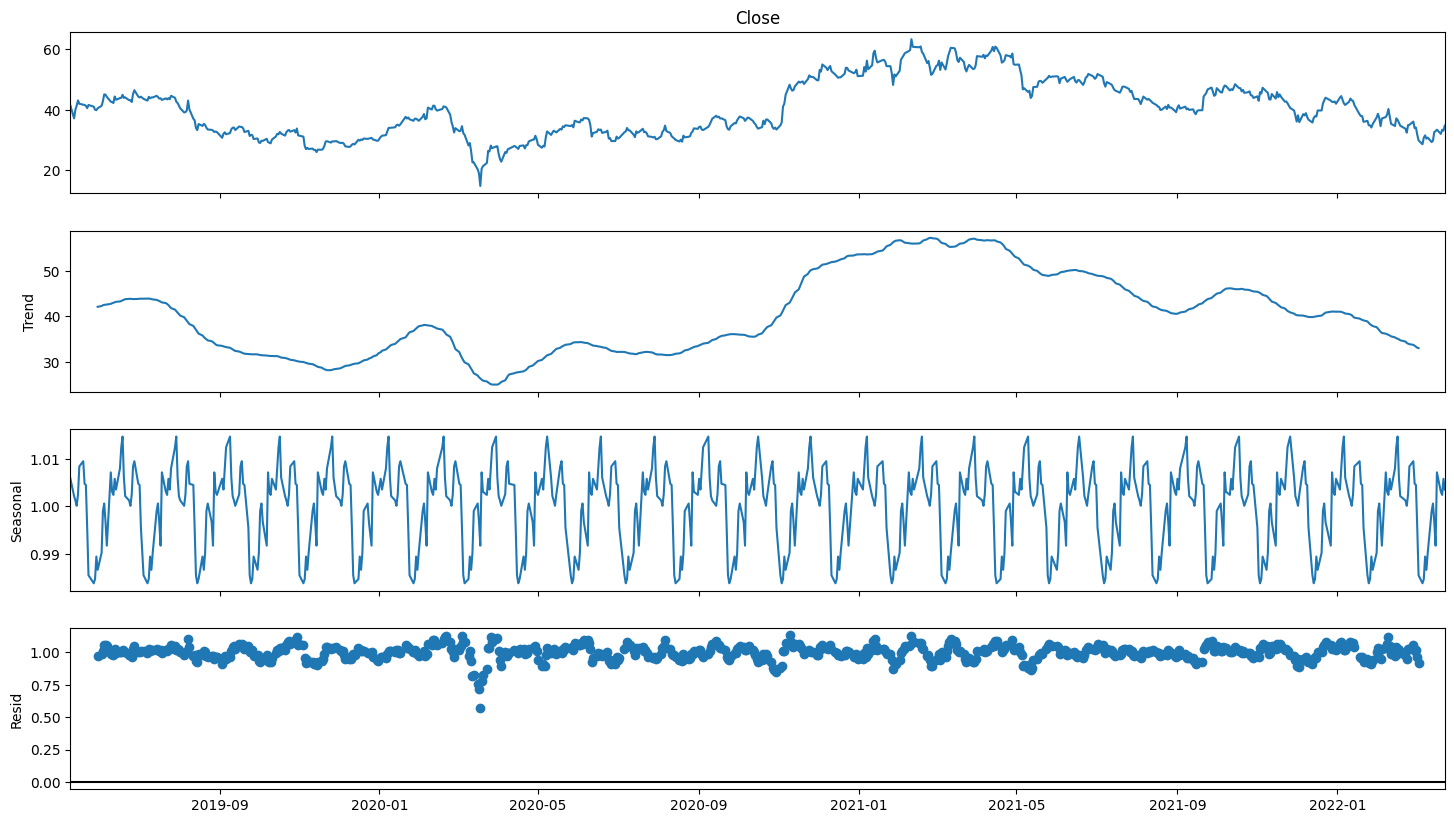

In [48]:
plt.style.use('default')
result = seasonal_decompose(df_close, model='multiplicative',period=28)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

Text(0.5, 1.0, 'Transformed data')

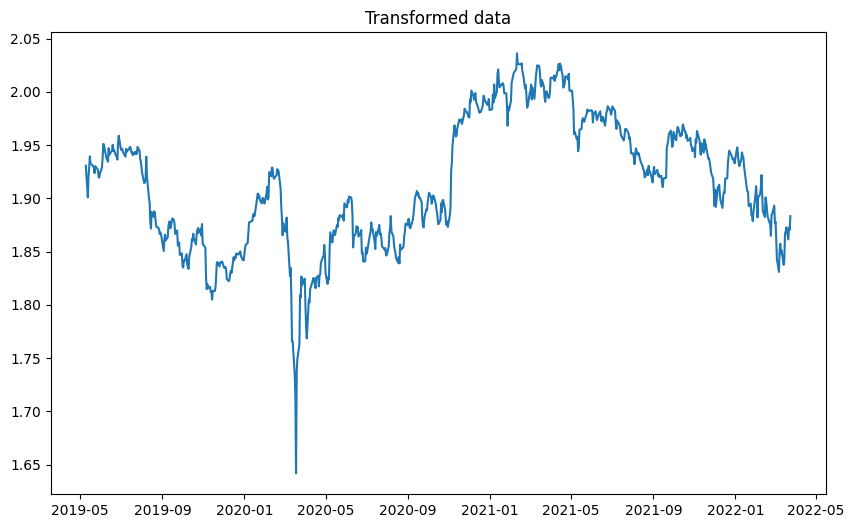

In [47]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)
plt.style.use('default')
plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data')

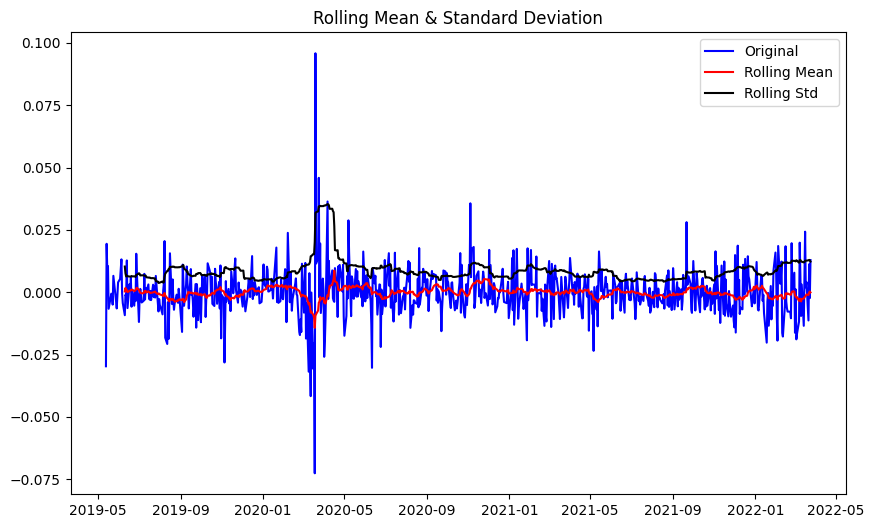

Results of Dickey-Fuller Test:
Test Statistic                -7.517646e+00
p-value                        3.865103e-11
#Lags Used                     1.100000e+01
Number of Observations Used    7.120000e+02
Critical Value (1%)           -3.439568e+00
Critical Value (5%)           -2.865608e+00
Critical Value (10%)          -2.568936e+00
dtype: float64


In [12]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

In [52]:
def preprocess_lstm(sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix >= len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

# Selecting prediction timeframe in days.

In [15]:
nb_days = 60

n_features = 1

X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

# Divide the dataset into training and test sets

In [16]:
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

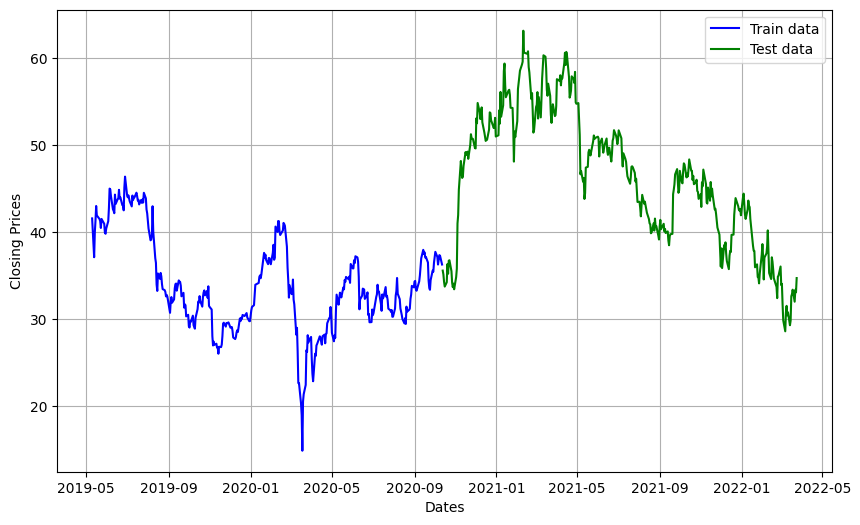

In [17]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend()

In [18]:
def vanilla_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(1))
    return model

In [19]:
model = vanilla_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
10/10 [==============================] - 10s 148ms/step - loss: 1.6264e-04 - mean_absolute_error: 0.0092
Epoch 2/15
10/10 [==============================] - 1s 78ms/step - loss: 1.5605e-04 - mean_absolute_error: 0.0087
Epoch 3/15
10/10 [==============================] - 1s 75ms/step - loss: 1.5295e-04 - mean_absolute_error: 0.0082
Epoch 4/15
10/10 [==============================] - 1s 73ms/step - loss: 1.4994e-04 - mean_absolute_error: 0.0083
Epoch 5/15
10/10 [==============================] - 1s 75ms/step - loss: 1.4674e-04 - mean_absolute_error: 0.0081
Epoch 6/15
10/10 [==============================] - 1s 74ms/step - loss: 1.4782e-04 - mean_absolute_error: 0.0079
Epoch 7/15
10/10 [==============================] - 1s 76ms/step - loss: 1.4690e-04 - mean_absolute_error: 0.0079
Epoch 8/15
10/10 [==============================] - 1s 75ms/step - loss: 1.5129e-04 - mean_absolute_error: 0.0079
Epoch 9/15
10/10 [==============================] - 1s 69ms/step - loss: 1.5158e-04 - 

# Evaluating the model using test data

In [53]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 [==============================] - 0s 13ms/step - loss: 6.9266e-05 - mean_absolute_error: 0.0075
Test MSE: 6.926598871359602e-05
Test MAE: 0.007483693305402994


# Prediction Analysis

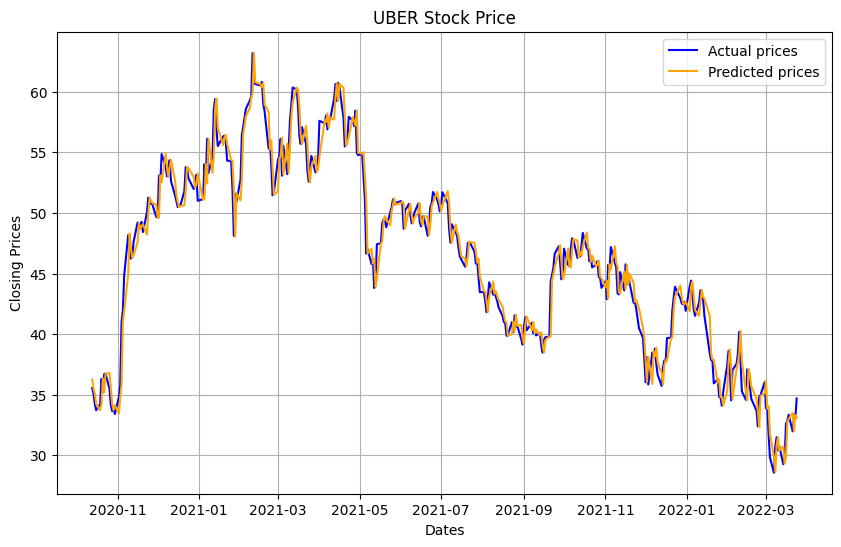

In [50]:
y_pred = model.predict(X_test)

pred_data = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])

pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:]

pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data, 'orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()

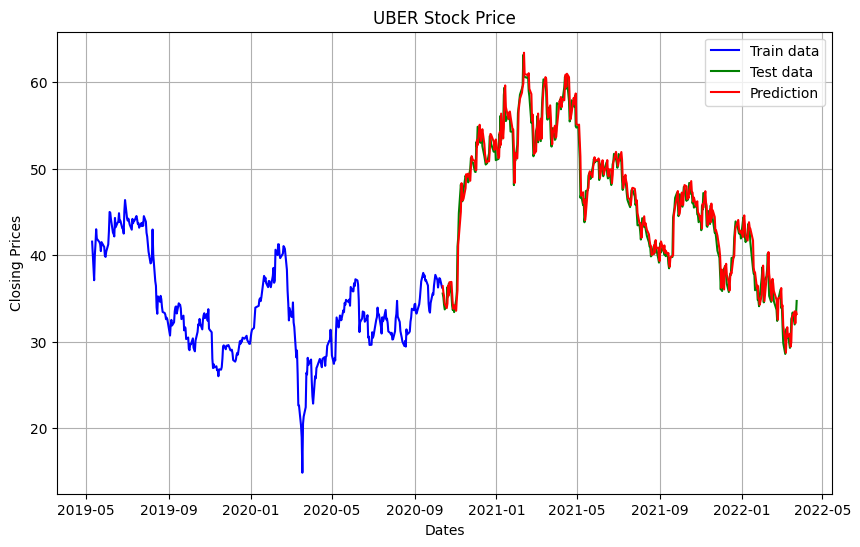

In [28]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.plot(pred_data, 'red', label='Prediction')
plt.title(company + ' Stock Price')
plt.legend()

In [25]:
def preprocess_multistep_lstm(sequence, n_steps_in, n_steps_out, features):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))

    return X, y

# Time horizon for future prediction compared to the historical basis

In [29]:
n_steps_out = 10

nb_days = 60

n_features = 1

X, y = preprocess_multistep_lstm(df_close_shift.to_numpy(), nb_days, n_steps_out, n_features)


# Split the data set between the training set and the test set

In [30]:
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

In [31]:
def vanilla_multistep_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(n_steps_out))
    return model

In [32]:
model = vanilla_multistep_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 10,910
Trainable params: 10,910
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
10/10 [==============================] - 3s 67ms/step - loss: 1.5256e-04 - mean_absolute_error: 0.0077
Epoch 2/15
10/10 [==============================] - 1s 71ms/step - loss: 1.5321e-04 - mean_absolute_error: 0.0079
Epoch 3/15
10/10 [==============================] - 1s 71ms/step - loss: 1.5107e-04 - mean_absolute_error: 0.0078
Epoch 4/15
10/10 [==============================] - 1s 69ms/step - loss: 1.5755e-04 - mean_absolute_error: 0.0078
Epoch 5/15
10/10 [==============================] - 1s 70ms/step - loss: 1.4998e-04 - mean_absolute_error: 0.0078
Epoch 6/15
10/10 [==============================] - 1s 109ms/step - loss: 1.5051e-04 - mean_absolute_error: 0.0078
Epoch 7/15
10/10 [==============================] - 1s 127ms/step - loss: 1.4791e-04 - mean_absolute_error: 0.0078
Epoch 8/15
10/10 [==============================] - 1s 118ms/step - loss: 1.4881e-04 - mean_absolute_error: 0.0077
Epoch 9/15
10/10 [==============================] - 1s 72ms/step - loss: 1.4736e-04 -

In [34]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)

print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 [==============================] - 2s 31ms/step - loss: 6.9266e-05 - mean_absolute_error: 0.0076
Test MSE: 6.926598871359602e-05
Test MAE: 0.007568656001240015


Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

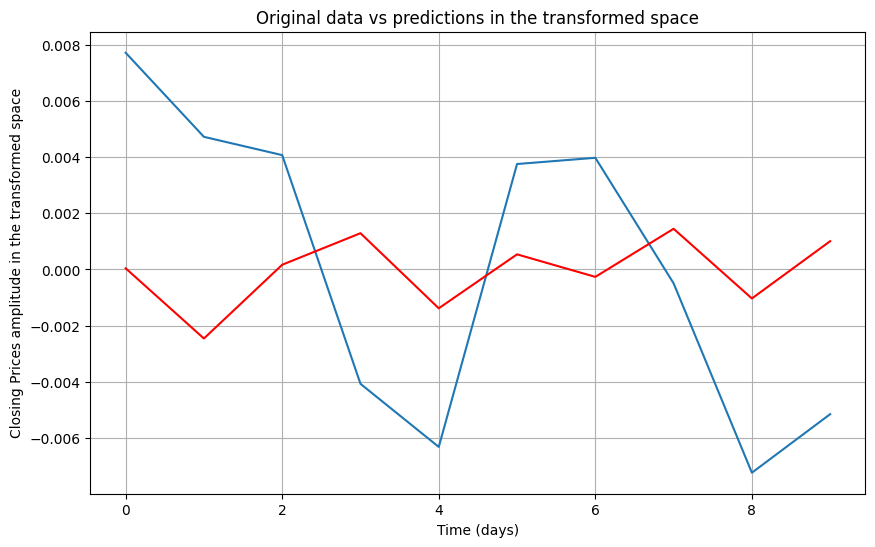

In [35]:
y_pred = model.predict(X_test)

the_day = 0
y_pred_days = y_pred[the_day,:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Closing Prices amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

In [36]:
pred_diff_cumsum = y_pred_days.cumsum()

base_number = df_close_tf.values[-test_days+the_day+nb_days-1]
idx = test_original.iloc[the_day:the_day+n_steps_out].index

pred_tf = pd.Series(base_number, index=idx)
pred_tf = pred_tf.add(pred_diff_cumsum,fill_value=0)

print(pred_tf)

Date
2020-10-13    2.006948
2020-10-14    2.004490
2020-10-15    2.004658
2020-10-16    2.005949
2020-10-19    2.004567
2020-10-20    2.005105
2020-10-21    2.004841
2020-10-22    2.006289
2020-10-23    2.005257
2020-10-26    2.006265
dtype: float64


In [37]:
pred_log = pred_tf.apply(np.square)
pred = pred_log.apply(np.exp)
print(pred)

Date
2020-10-13    56.139541
2020-10-14    55.588817
2020-10-15    55.626214
2020-10-16    55.914967
2020-10-19    55.605813
2020-10-20    55.725953
2020-10-21    55.666941
2020-10-22    55.991328
2020-10-23    55.760026
2020-10-26    55.985763
dtype: float64


# Plotting actual prices vs predicted prices

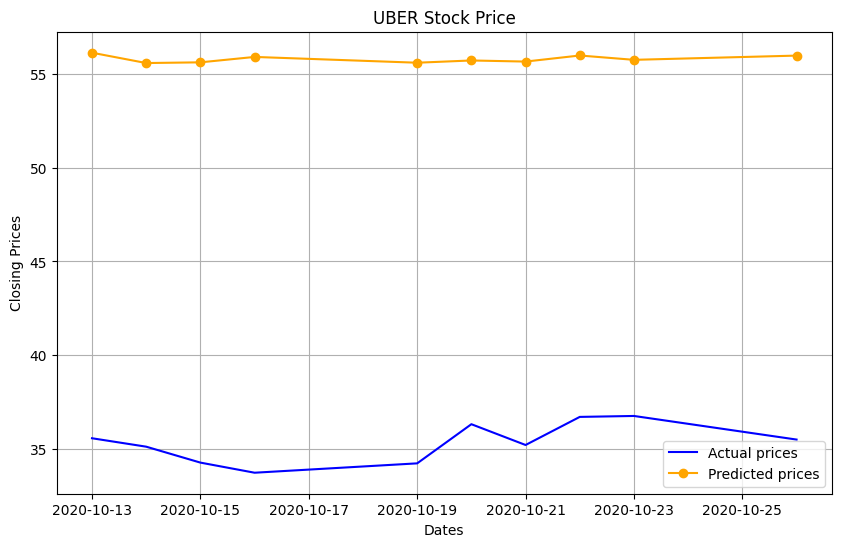

In [38]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original.iloc[max(0,the_day-30):the_day+n_steps_out],'b',label='Actual prices')
plt.plot(pred, '-o',color='orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()